## Load dependencies

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# cd /content/drive/MyDrive/Training/UNet

In [3]:
import os

import torch 
import torch.nn as nn
from torch.optim import SGD, Adam, RMSprop
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset

from PIL import Image, ImageOps
import matplotlib.pyplot as plt

from unet.Unet import *

/Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <CAE66874-17C2-35C9-9C4D-6BA9770AF17F> /Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <459875AA-DE2C-366B-9C44-90D4B3887080> /Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


#### Update-1: To increase train time
   - Store low resolution(decent) images locally and then load to data loader
   - Increase batch size - will increase gpu utilisation, will increase performance. Don't have it too high. Can lead to overfitting
   
   - Apply some augmentation so that increasing batch size won't quickly leadly to overfitting.
    

In [4]:
# %%time
# input_dir = ['data/imgs', 'data/masks']
# output_dir = ['data_resized/imgs','data_resized/masks']

# size = (576, 576)
# for i in range(2):
#     for filename in os.listdir(input_dir[i]):
#         img = Image.open(os.path.join(input_dir[i], filename))

#         img_resized = img.resize(size)

#         output_path = os.path.join(output_dir[i], filename)
#         img_resized.save(output_path)

In [5]:
device = 'mps'

In [6]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    #  576 choosen because, height and width would be even after 4 maxpooling
#     transforms.Resize([576, 576]),
])

## Dataset preparation

In [7]:
class SegmentationDataset(Dataset):
    
    def __init__(self, imagePaths, maskPaths, transforms):

        self.imagefiles = os.listdir(imagePaths)
        self.maskfiles = os.listdir(maskPaths)
        
        if  '.DS_Store' in self.imagefiles:
            self.imagefiles.remove( '.DS_Store')
        if  '.DS_Store' in self.maskfiles:
            self.maskfiles.remove( '.DS_Store')
            
        self.imagefiles.sort()
        self.maskfiles.sort()
    
        for i in range(len(self.imagefiles)):
            self.imagefiles[i] = os.path.join(imagePaths,self.imagefiles[i])
            self.maskfiles[i] = os.path.join(maskPaths, self.maskfiles[i])
        
        self.transforms = transforms
        
    def __len__(self):
        return len(self.imagefiles)
    
    def __getitem__(self, idx):
        imagePath = self.imagefiles[idx]
        maskPath = self.maskfiles[idx]
        
        image =Image.open(imagePath)
        #m = Image.open(maskPath).convert('A')
        mask =Image.open(maskPath)
        mask = ImageOps.grayscale(mask)
        
        image = self.transforms(image)
        mask = self.transforms(mask)
        
        return (image, mask)

In [8]:
dataset = SegmentationDataset('data_resized/imgs', 'data_resized/masks', train_transform)

## Prepare Dataloader

In [9]:
torch.manual_seed(1)

total = len(dataset)
train_size = 0.75

train_total = int(train_size * total)
test_total = int((1-train_size )* total)

valid_total =  int((1-train_size) * train_total)
actual_train_total = int(train_size * train_total)


print(f'Train size: {actual_train_total} \nValidation Size: {valid_total} \nTest Size: {test_total}') 

Train size: 2862 
Validation Size: 954 
Test Size: 1272


In [10]:
randomised_idx = torch.randperm(total)

data_train = Subset(dataset, randomised_idx[:train_total])
data_test = Subset(dataset, randomised_idx[train_total: ])

data_train = Subset(dataset,randomised_idx[:actual_train_total])
data_valid = Subset(dataset, randomised_idx[actual_train_total: actual_train_total + valid_total])

In [11]:
len(data_train), len(data_valid), len(data_test)

(2862, 954, 1272)

In [12]:
data = DataLoader(data_train, batch_size=5, shuffle=True)
data_vl = DataLoader(data_valid, batch_size=5, shuffle=True)

In [13]:
next(iter(data))[0].shape

torch.Size([5, 3, 576, 576])

## Visualise data

In [14]:
import numpy as np

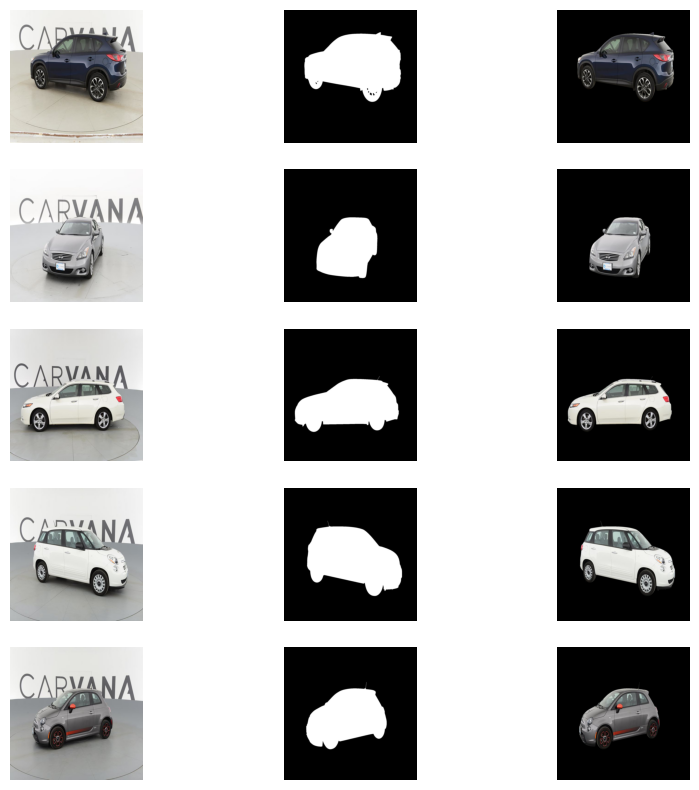

In [15]:
viz_data = DataLoader(data_train, 5, shuffle=False)

image_batch, mask_batch = next(iter(viz_data))
plt.figure(figsize=(10,10))

for i in range(1,16, 3):
    image_proper = (image_batch[i//3].permute(1,2,0))
    mask_proper = (mask_batch[i//3].permute(1,2,0))
    
    plt.subplot(5,3,i)
    plt.axis('off')
    plt.imshow(image_proper)
    
    plt.subplot(5,3,i+1)
    plt.axis('off')

    plt.imshow(mask_proper.squeeze(2), cmap='gray')
    
    plt.subplot(5,3,i+2)
    mask = mask_proper.permute(2,0,1)
    mask = transforms.ToPILImage()(mask)
    mask = transforms.Grayscale(num_output_channels=3)(mask)
    image_masked = transforms.functional.pil_to_tensor(mask) * image_proper.permute(2,0,1)

    image_masked = image_masked.numpy().transpose(1, 2, 0)
    plt.axis('off')
    plt.imshow(np.uint8(image_masked))
    

plt.show()

## Training step

In [16]:
model = UNet(3, 1)
model

UNet(
  (initial): InsideBlockConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): ContractionBlock(
    (contraction): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): InsideBlockConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm

In [17]:
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.99)
loss_fn = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()


In [18]:
from torchmetrics import JaccardIndex # i.e IoU

In [19]:
def train(model, epoch, data, data_vl):
    train_loss = [0] * epoch
    train_jaccard = [0] * epoch
    validation_loss = [0] * epoch
    validation_jaccard = [0] * epoch
    for i in range(epoch):
        for x_batch, y_batch in data:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss[i] += (loss.item() * x_batch.size(0))
            
            y_batch = y_batch.to(torch.int)
            pred = torch.sigmoid(pred) ## Must needed
            pred = torch.round(pred).to(torch.int)
            jaccard = JaccardIndex(task="binary")
            #print(jaccard(pred.cpu(), y_batch.cpu()))
            train_jaccard[i] += jaccard(pred.cpu(), y_batch.cpu()) ## Find out how it is calculated with batch size
            
        div = len(data.dataset)//data.batch_size
        
        train_loss[i] /= len(data.dataset)
        train_jaccard[i] /= div
        print('Train over, validation begins...')
        with torch.no_grad():
            for x_batch, y_batch in data_vl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                validation_loss[i] += (loss.item() * x_batch.size(0))
                
                y_batch = y_batch.to(torch.int) 
                pred = torch.sigmoid(pred)
                pred = torch.round(pred).to(torch.int)

                jaccard = JaccardIndex(task="binary")
                validation_jaccard[i] += jaccard(pred.cpu(), y_batch.cpu())
                
            div = len(data_vl.dataset)//data_vl.batch_size
            validation_loss[i] /= len(data_vl.dataset)
            validation_jaccard[i] /= div
        print(f'Epoch {i+1} \nloss: {train_loss[i]:.4f} val_loss:{validation_loss[i]:.4f}\njaccard: {train_jaccard[i]:.4f} val_jaccard:{validation_jaccard[i]:.4f}')
        print()
    return train_loss, train_jaccard, validation_loss, validation_jaccard

In [20]:
data_sub_train = Subset(data_train, np.arange(1000))

In [21]:
datasub = DataLoader(data_sub_train, batch_size=5, shuffle=True)

In [22]:
%%time
### When train batch size=16 and validation batch=1,  resized image loaded by dataloader
  
model = model.to(device)
epoch = 4
train_loss, train_iou, validation_loss, validation_iou = train(model, epoch, datasub, data_vl)

KeyboardInterrupt: 

In [22]:
### When train batch size=64, 32, 16 and validation batch=8,  resized image loaded by dataloader
# %%time  
# model = model.to(device)
# epoch = 4
# train_loss, train_iou, validation_loss, validation_iou = train(model, epoch, datasub, data_vl)

Train over, validation begins...
Epoch 1 
loss: 0.0798 val_loss:0.0528
jaccard: 0.8519 val_jaccard:0.1120

Train over, validation begins...
Epoch 2 
loss: 0.0304 val_loss:0.0324
jaccard: 0.9266 val_jaccard:0.1164

Train over, validation begins...


KeyboardInterrupt: 

#### Note we can clearly witness than below I had batch size of 1, so it learned properly(I expected under fitting), But When I increase the batch size to 64 it leads to ovr fitting

#### Doubt:
- Able to train with 64 as batch size. But unable to use 32 as batch size for validation

In [193]:
## When batch size=1 and image is resized only in data loader
# %%time
# model = model.to(device)
# epoch = 4
# train_loss, train_iou, validation_loss, validation_iou = train(model, epoch, datasub, data_vl)

Train over, validation begins...
Epoch 1 
loss: 0.0900 val_loss:0.0388
jaccard: 0.8405 val_jaccard:0.9241

Train over, validation begins...
Epoch 2 
loss: 0.0327 val_loss:0.0228
jaccard: 0.9335 val_jaccard:0.9500

Train over, validation begins...
Epoch 3 
loss: 0.0198 val_loss:0.0222
jaccard: 0.9543 val_jaccard:0.9550

Train over, validation begins...
Epoch 4 
loss: 0.0173 val_loss:0.0184
jaccard: 0.9583 val_jaccard:0.9594

CPU times: user 13min 58s, sys: 8min 20s, total: 22min 19s
Wall time: 1h 23min 50s


In [19]:
ls

LICENSE             Segmentation.ipynb  download.sh*        unet/
README.md           data/               images/


In [127]:
len(data_test)

1272

In [194]:
image , mask = data_test[120][0], data_test[120][1]

image = image.unsqueeze(0)
image = image.to(device)

pred = model(image).squeeze(0).cpu().detach()
image = image.squeeze(0).cpu()
print(pred)
pred = torch.round(pred) ## Must needed for proper segmented display
print(pred)

tensor([[[ -6.4329,  -6.4695,  -6.9516,  ...,  -7.0629,  -6.8542,  -6.8517],
         [ -6.2746,  -7.0643,  -7.9846,  ...,  -8.2242,  -7.7596,  -6.7081],
         [ -6.5997,  -7.8438,  -8.6692,  ...,  -9.2444,  -8.6582,  -7.0901],
         ...,
         [ -6.6338,  -7.5934,  -8.9373,  ..., -10.4632,  -9.6631,  -7.6727],
         [ -6.3003,  -7.2312,  -8.4898,  ..., -10.1194,  -9.4214,  -7.5093],
         [ -6.2480,  -6.2576,  -6.8752,  ...,  -7.8617,  -7.3412,  -6.3625]]])
tensor([[[ -6.,  -6.,  -7.,  ...,  -7.,  -7.,  -7.],
         [ -6.,  -7.,  -8.,  ...,  -8.,  -8.,  -7.],
         [ -7.,  -8.,  -9.,  ...,  -9.,  -9.,  -7.],
         ...,
         [ -7.,  -8.,  -9.,  ..., -10., -10.,  -8.],
         [ -6.,  -7.,  -8.,  ..., -10.,  -9.,  -8.],
         [ -6.,  -6.,  -7.,  ...,  -8.,  -7.,  -6.]]])


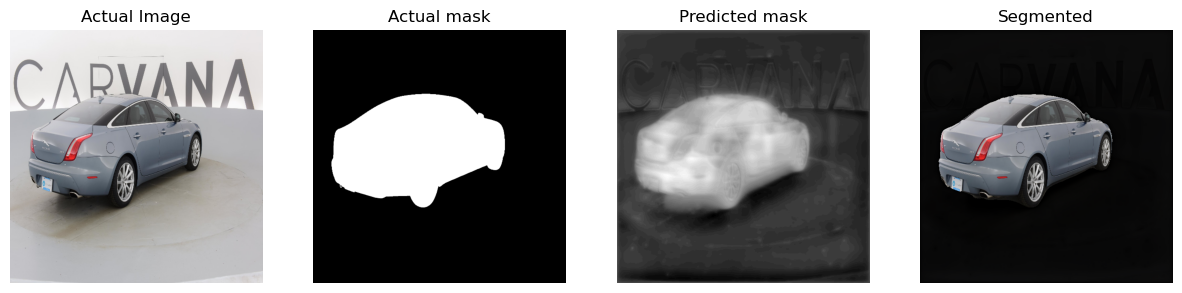

In [195]:
image_proper = (image.permute(1,2,0))
mask_proper = (mask.permute(1,2,0))
predicted_mask_proper = (pred.permute(1,2,0))

plt.figure(figsize=(15,35))
plt.tight_layout()
plt.subplot(5,4,i)
plt.title('Actual Image')
plt.axis('off')
plt.imshow(image_proper)

plt.subplot(5,4,i+1)
plt.title('Actual mask')
plt.axis('off')
plt.imshow(mask_proper.squeeze(2), cmap='gray')

plt.subplot(5,4,i+2)
plt.title('Predicted mask')
plt.axis('off')
plt.imshow(predicted_mask_proper.squeeze(2), cmap='gray')

plt.subplot(5,4,i+3)
plt.title('Segmented')
mask = predicted_mask_proper.permute(2,0,1)
mask = transforms.ToPILImage()(mask)
mask = transforms.Grayscale(num_output_channels=3)(mask)
image_masked = transforms.functional.pil_to_tensor(mask) * image_proper.permute(2,0,1)

image_masked = image_masked.numpy().transpose(1, 2, 0)
plt.axis('off')
plt.imshow(np.uint8(image_masked))

**Note**
- In just 1 epoch it outputs reasonably good mask. I am sticking to 4 epoch and that too with not the complete train data. I use only 1000 training data size because of limited computing resource locally.
    - My free colab plan is exausted 🙃
- Will have to improve the training strategies, possibly divide the input image into large tiles and finally generate the output mask.S